#Fake News Detection using Machine Learning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
data = pd.read_csv('News.csv', index_col=0)
data.head()

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


Data preprocessing


In [20]:
data.shape

(44919, 5)

In [21]:
data=data.drop(['title','subject','date'],axis=1)
data.isnull().sum()


text     0
class    0
dtype: int64

Shuffle the dataset to prevent the model to get bias. After that we will reset the index and then drop it. Because index column is not useful to us.

In [22]:
data= data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(['index'],axis=1, inplace=True)

Explore the unique values in the each category using below code.

<Axes: xlabel='class', ylabel='count'>

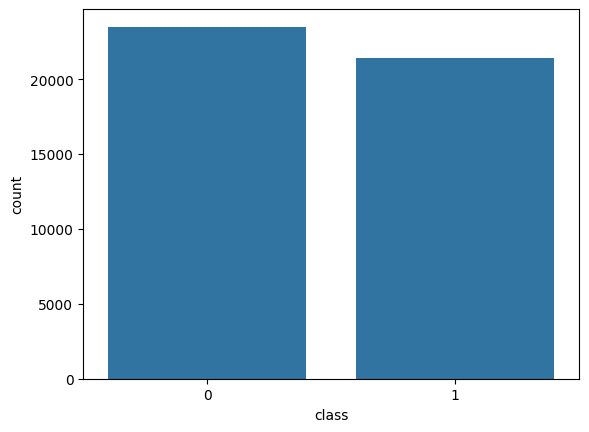

In [23]:
sns.countplot(data=data,
              x='class',
              order=data['class'].value_counts().index)

Preprocessing and analysis of News column

Firstly we will remove all the stopwords, punctuations and any irrelevant spaces from the text

In [24]:
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Function "preprocess text".

This function will preprocess all the data given as input.

In [28]:
def preprocess_text(text_data):
  preprocessed_text=[]

  for sentence in tqdm(text_data):
    sentense = re.sub(r'[^\w\s]', '', sentence)
    preprocessed_text.append(' '.join(token.lower()
                              for token in str(sentense).split()
                              if token not in stopwords.words('english')))
  return preprocessed_text

preprocessed_review = preprocess_text(data['text'].values)
data['text'] = preprocessed_review

100%|██████████| 44919/44919 [26:07<00:00, 28.66it/s]


Visualize the WordCloud for fake and real news separately.

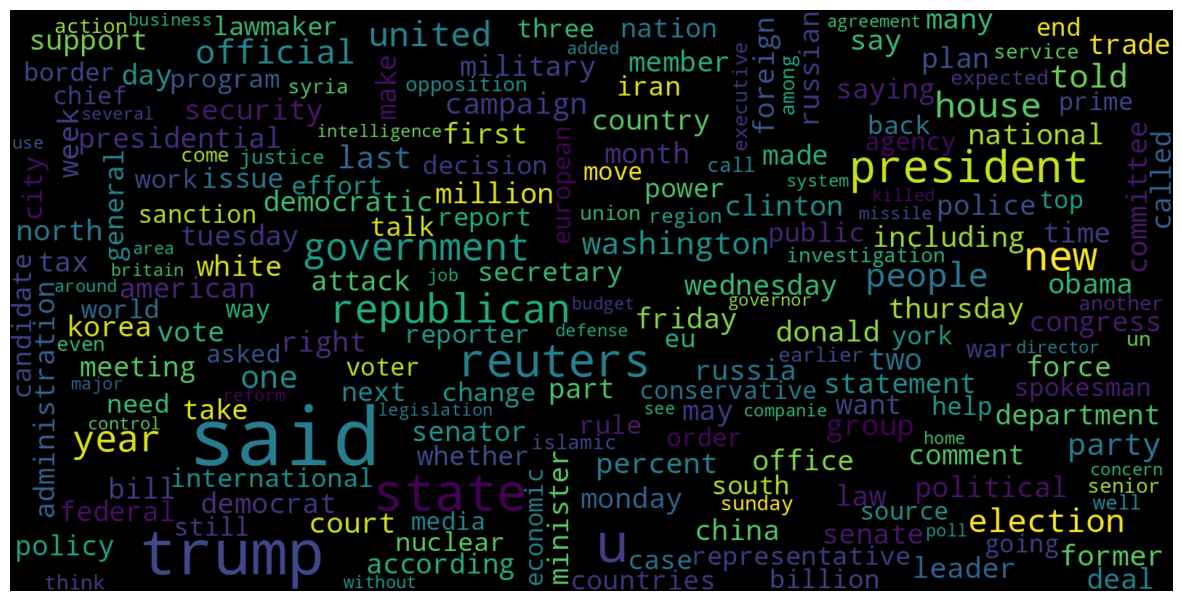

In [30]:
#Real
consolidated = ' '.join(
    word for word in data['text'][data['class']==1].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()


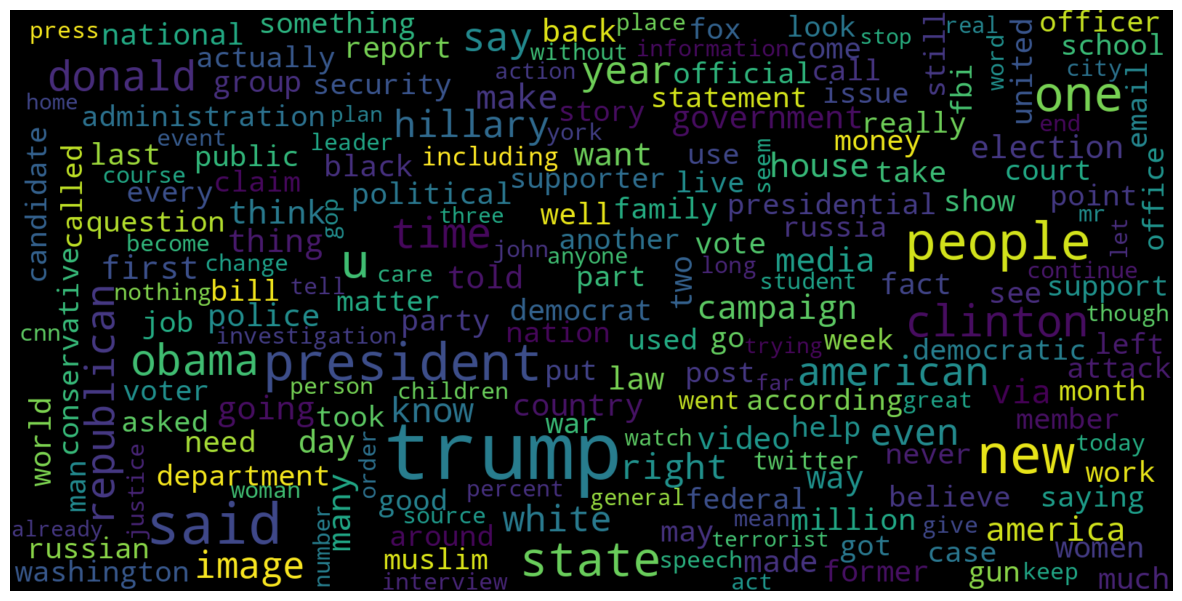

In [31]:
#Fake
consolidated = ' '.join(
    word for word in data['text'][data['class']==0].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()


Plot the bargraph of the top 20 most frequent words.



<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

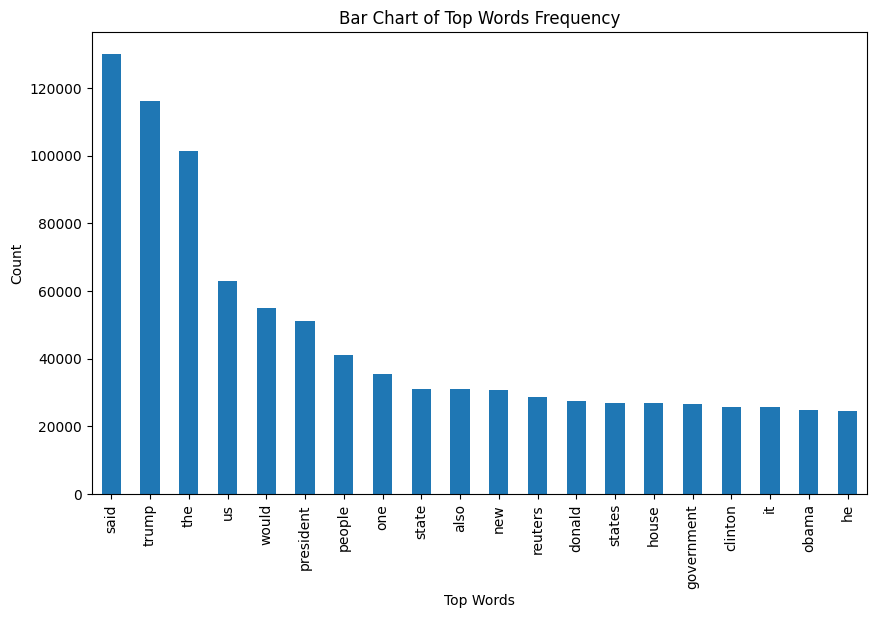

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
  vec = CountVectorizer().fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx])
                for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key=lambda x: x[1],
                      reverse=True)
  return words_freq[:n]

common_words = get_top_n_words(data['text'],20)
df1 = pd.DataFrame(common_words , columns=['Review','count'])

df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    xlabel="Top Words",
    ylabel="Count",
    title="Bar Chart of Top Words Frequency"
)

#Text into Vector
train test split

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

X_train , X_test , y_train , y_test = train_test_split(data['text'],data['class'],
                                                       test_size=0.3)

Convert the training data into vectors

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
X_train = vectorization.fit_transform(X_train)
X_test = vectorization.transform(X_test)



#Model training, Evaluation, and Prediction

Logistic Regression and accuracy score

In [40]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

print(accuracy_score(y_train, model.predict(X_train)))
print(accuracy_score(y_test, model.predict(X_test)))

0.9933212479725217
0.9890175126150192


 Decision Tree Classifier

0.9999681964189168
0.9971059661620659


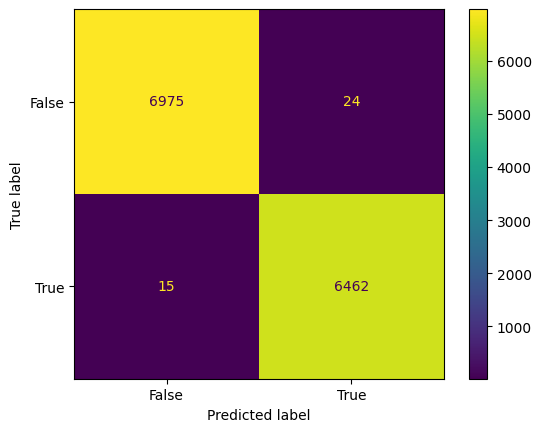

In [43]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

print(accuracy_score(y_train, model.predict(X_train)))
print(accuracy_score(y_test, model.predict(X_test)))


from sklearn import metrics
cm=metrics.confusion_matrix(y_test, model.predict(X_test))

cm_display=metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                          display_labels=[False,True])
cm_display.plot()
plt.show()

Conclusion
Decision Tree Classifier and Logistic regression are performing well.